In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import pickle
from cpymad.madx import Madx
from pybt.tools.plotters import *
from madxtools.plot_tool import *
from madxtools.air_scattering import *
import requests
from scipy.optimize import curve_fit

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

In [2]:
with open('MWPC_quadrupole_scan_run.pickle', 'rb') as f:
    data = pickle.load(f)

with open('Quadrupole_scan_run.pickle', 'rb') as f:
    df_quadrupoles = pickle.load(f)

selector = "CPS.USER.MD3"

In [7]:
data.keys()

Index(['__record_timestamp__', '__record_version__', 'acqMsg', 'acqStamp',
       'acqState', 'acqTime', 'beamID', 'class', 'coincidenceDeviceName',
       'cycleTime', 'cyclestamp', 'device', 'deviceDetailedStatus',
       'deviceHwStatus', 'deviceName', 'equipmentName', 'event', 'gasOk',
       'highVoltage', 'highVoltageMode', 'highVoltageOn', 'highVoltageStatus',
       'inOutPosition', 'moduleWdAcquisition', 'moduleWdMonitor',
       'profileHoriz', 'profileHorizFiltered', 'profileHorizOffset1',
       'profileHorizOffset8', 'profileVert', 'profileVertFiltered',
       'profileVertOffset1', 'profileVertOffset8', 'property', 'selector',
       'superCycleNb', 'wireSpacingHorz', 'wireSpacingVert',
       'nxcals_entity_id', 'timestamp'],
      dtype='object')

In [8]:
data = data[["selector", "timestamp", "profileHoriz", "profileVert"]]
data.head(3)

selector               timestamp  \
989  CPS.USER.MD3 2023-10-28 19:00:34.001   
152  CPS.USER.MD3 2023-10-28 19:00:41.201   
822  CPS.USER.MD3 2023-10-28 19:01:31.601   

                                          profileHoriz  \
989  {'elements': [-0.126953125, -0.1318359375, -0....   
152  {'elements': [-0.126953125, -0.126953125, -0.1...   
822  {'elements': [-0.1220703125, -0.126953125, -0....   

                                           profileVert  
989  {'elements': [-0.1220703125, -0.1171875, -0.11...  
152  {'elements': [-0.1171875, -0.1171875, -0.12695...  
822  {'elements': [-0.1123046875, -0.107421875, -0....

In [4]:
df_quadrupoles.head(3)

timestamp      selector  avg_flattop_Gauss      Ekin  \
0 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
1 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
2 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   

        Brho     current            magnet_name   type        k1  
0  35.828267  268.998108  F61.QFN007/MEAS.PULSE   Q74L  0.478035  
1  35.828267   88.007484  T08.QFN066/MEAS.PULSE  Q200L  0.068845  
2  35.828267  143.633881  F61.QDN014/MEAS.PULSE  Q120C  0.209318

In [26]:
sigH_measurement_list = []
sigV_measurement_list = []
sigH_error_list = []
sigV_error_list = []

for index, row in data.iterrows():
    target_timestamp = row['timestamp']
    selector = row['selector']

    differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
    closest_index = differences.idxmin()

    MWPC_wire = np.linspace(93, -93, num=32)
    
    # Horizontal Measurement and Gaussian Fit
    try:
        y = data.loc[closest_index, 'profileHoriz']['elements'][0:32]
        popt, pcov = do_gaussian_fit(MWPC_wire, y)
        sigH_measurement_list.append(popt[3])
        perr = np.sqrt(np.diag(pcov))
        sigH_error_list.append(perr[3])
    except:
        sigH_measurement_list.append(np.nan)
        sigH_error_list.append(np.nan)



    # Vertical Measurement and Gaussian Fit
    try:
        y = data.loc[closest_index, 'profileVert']['elements'][0:32]
        poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
        sigV_measurement_list.append(poptV[3])
        sigV_error_list.append(np.sqrt(np.diag(pcovV))[3])
    except:
        sigV_measurement_list.append(np.nan)
        sigV_error_list.append(np.nan)

# Adding new columns to the data DataFrame
data['sigH_meas'] = sigH_measurement_list
data['sigV_meas'] = sigV_measurement_list
data['sigH_meas_error'] = sigH_error_list
data['sigV_meas_error'] = sigV_error_list

In [33]:
data = data[["selector", "timestamp", "sigH_meas", "sigV_meas", "sigH_meas_error", "sigV_meas_error"]]

(0.0, 100.0)

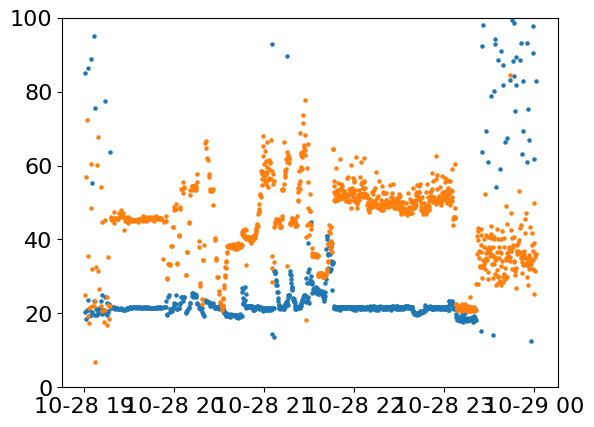

In [37]:
fig, ax = plt.subplots()
ax.scatter(data.timestamp, data.sigH_meas, label='Horizontal', s=5)
ax.scatter(data.timestamp, data.sigV_meas, label='Vertical',s=5)
ax.set_ylim(0,100)

In [38]:
data.keys()

Index(['selector', 'timestamp', 'sigH_meas', 'sigV_meas', 'sigH_meas_error',
       'sigV_meas_error'],
      dtype='object')

In [42]:
df_quadrupoles = df_quadrupoles[["selector", "timestamp", "magnet_name", "k1"]]

In [43]:
df_quadrupoles.keys()

Index(['selector', 'timestamp', 'magnet_name', 'k1'], dtype='object')

In [40]:
df_quadrupoles.head(3)

timestamp      selector  avg_flattop_Gauss      Ekin  \
0 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
1 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
2 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   

        Brho     current            magnet_name   type        k1  
0  35.828267  268.998108  F61.QFN007/MEAS.PULSE   Q74L  0.478035  
1  35.828267   88.007484  T08.QFN066/MEAS.PULSE  Q200L  0.068845  
2  35.828267  143.633881  F61.QDN014/MEAS.PULSE  Q120C  0.209318

In [44]:
df_pivoted = df_quadrupoles.pivot_table(index='timestamp', columns='magnet_name', values='k1', aggfunc='first').reset_index()


In [45]:
df_pivoted.head(3)

magnet_name                     timestamp  F61.QDN014/MEAS.PULSE  \
0           2023-10-28 19:00:34.298238525               0.209318   
1           2023-10-28 19:00:41.498238525               0.209317   
2           2023-10-28 19:01:31.898238525               0.208871   

magnet_name  F61.QDN030/MEAS.PULSE  F61.QFN007/MEAS.PULSE  \
0                         0.090045               0.478035   
1                         0.090047               0.478034   
2                         0.089851               0.476998   

magnet_name  F61.QFN021/MEAS.PULSE  T08.QDN023/MEAS.PULSE  \
0                         0.197992               0.193833   
1                         0.197997               0.193829   
2                         0.197566               0.193408   

magnet_name  T08.QDN061/MEAS.PULSE  T08.QFN021/MEAS.PULSE  \
0                         0.061122               0.195463   
1                         0.061121               0.195465   
2                         0.060990               0.195042   

magnet_name  T08.QFN066/MEAS.PULSE  
0                         0.068845  
1                         0.068845  
2                         0.068695

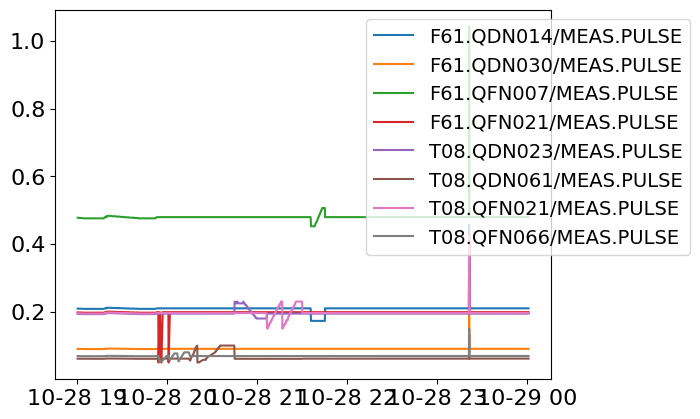

In [47]:
fig, ax = plt.subplots()
for magnet_name in df_pivoted.columns[1:]:
    ax.plot(df_pivoted.timestamp, df_pivoted[magnet_name], label=magnet_name)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

In [51]:
import pandas as pd

# Assuming df_data and df_pivoted are the two dataframes you want to merge
# Ensure both dataframes are sorted by timestamp
data.sort_values('timestamp', inplace=True)
df_pivoted.sort_values('timestamp', inplace=True)

# Merge using merge_asof
merged_df = pd.merge_asof(data, df_pivoted, on='timestamp', direction='nearest')

# Now merged_df will contain the combined data with each row from df_data merged to the closest row from df_pivoted based on timestamp.


/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_64934/1748580242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('timestamp', inplace=True)


In [52]:
merged_df

selector               timestamp   sigH_meas   sigV_meas  \
0     CPS.USER.MD3 2023-10-28 19:00:34.001   84.944610  122.397159   
1     CPS.USER.MD3 2023-10-28 19:00:41.201   20.350074   24.948627   
2     CPS.USER.MD3 2023-10-28 19:01:31.601   18.360569   57.012711   
3     CPS.USER.MD3 2023-10-28 19:01:38.801   21.022989   72.293304   
4     CPS.USER.MD3 2023-10-28 19:02:29.201   86.519875   35.586448   
...            ...                     ...         ...         ...   
1057  CPS.USER.MD3 2023-10-29 00:00:02.801  320.958280   38.914785   
1058  CPS.USER.MD3 2023-10-29 00:00:08.801  137.571088   31.501453   
1059  CPS.USER.MD3 2023-10-29 00:00:38.801  113.877649   36.002375   
1060  CPS.USER.MD3 2023-10-29 00:00:47.201  107.591709   35.194948   
1061  CPS.USER.MD3 2023-10-29 00:01:00.401   82.966225   35.996476   

      sigH_meas_error  sigV_meas_error  F61.QDN014/MEAS.PULSE  \
0           75.947983       183.221958               0.209318   
1            4.787409         7.418649               0.209317   
2            4.148762        26.837755               0.208871   
3            6.975308        64.955835               0.208869   
4          107.486773        13.761596               0.208864   
...               ...              ...                    ...   
1057     11495.655609        20.283936               0.210006   
1058       465.478422         8.182457               0.210004   
1059       325.684087        15.563676               0.210001   
1060       232.746467        10.699815               0.209995   
1061        96.403428        13.004030               0.210002   

      F61.QDN030/MEAS.PULSE  F61.QFN007/MEAS.PULSE  F61.QFN021/MEAS.PULSE  \
0                  0.090045               0.478035               0.197992   
1                  0.090047               0.478034               0.197997   
2                  0.089851               0.476998               0.197566   
3                  0.089852               0.477001               0.197564   
4                  0.089853               0.476993               0.197565   
...                     ...                    ...                    ...   
1057               0.090342               0.479571               0.198648   
1058               0.090341               0.479576               0.198647   
1059               0.090345               0.479572               0.198649   
1060               0.090344               0.479576               0.198634   
1061               0.090340               0.479578               0.198637   

      T08.QDN023/MEAS.PULSE  T08.QDN061/MEAS.PULSE  T08.QFN021/MEAS.PULSE  \
0                  0.193833               0.061122               0.195463   
1                  0.193829               0.061121               0.195465   
2                  0.193408               0.060990               0.195042   
3                  0.193409               0.060986               0.195042   
4                  0.193409               0.060990               0.195039   
...                     ...                    ...                    ...   
1057               0.194353               0.061466               0.196066   
1058               0.194373               0.061466               0.196095   
1059               0.194372               0.061474               0.196075   
1060               0.194355               0.061469               0.196091   
1061               0.194369               0.061467               0.196073   

      T08.QFN066/MEAS.PULSE  
0                  0.068845  
1                  0.068845  
2                  0.068695  
3                  0.068692  
4                  0.068696  
...                     ...  
1057               0.069149  
1058               0.069147  
1059               0.069138  
1060               0.069152  
1061               0.069141  

[1062 rows x 14 columns]

<ErrorbarContainer object of 3 artists>

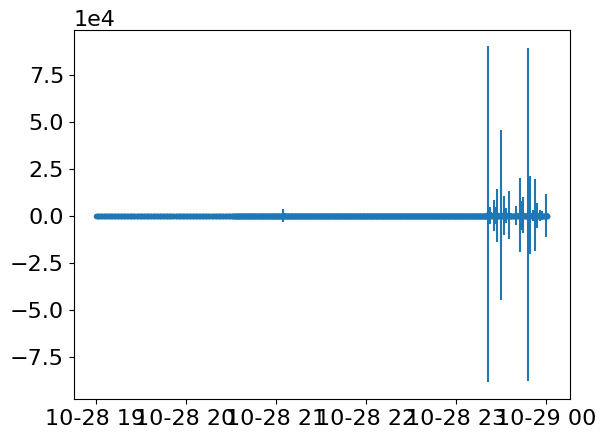

In [58]:
fig, ax = plt.subplots()
ax.errorbar(merged_df.["T08.QFN066/MEAS.PULSE"], merged_df.sigH_meas, yerr=merged_df.sigH_meas_error, label='Horizontal', fmt='o', markersize=3)

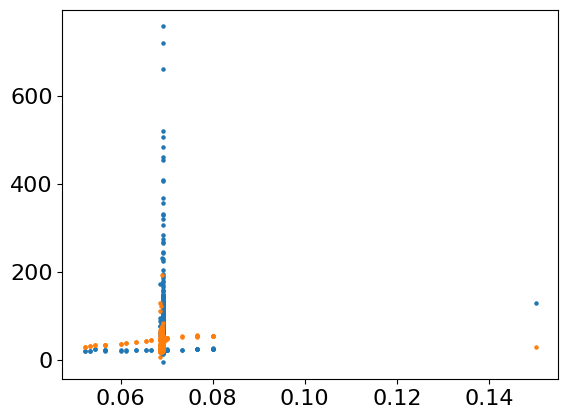

In [57]:
fig, ax = plt.subplots()
ax.scatter(merged_df['T08.QFN066/MEAS.PULSE'], merged_df['sigH_meas'], label='Horizontal', s=5)
ax.scatter(merged_df['T08.QFN066/MEAS.PULSE'], merged_df['sigV_meas'], label='Vertical', s=5)

In [ ]:
df_quadrupoles.head(3)

timestamp      selector  avg_flattop_Gauss      Ekin  \
0 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
1 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   
2 2023-10-28 19:00:34.298238525  CPS.USER.MD3             5112.5  2.008556   

        Brho     current            magnet_name   type        k1  
0  35.828267  268.998108  F61.QFN007/MEAS.PULSE   Q74L  0.478035  
1  35.828267   88.007484  T08.QFN066/MEAS.PULSE  Q200L  0.068845  
2  35.828267  143.633881  F61.QDN014/MEAS.PULSE  Q120C  0.209318